# Initialisation du notebook

L'objectif du module est de développer un système de suggestion de tag pour le site Stack Overflow. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

Ce notebook se consacre au processing des données textuelles.

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold=10

<IPython.core.display.Javascript object>

In [2]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os, pickle, warnings
from sklearn.utils import resample
import re, spacy, nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from string import punctuation

# no recognition of dependency labels and named entities 
nlp = spacy.load('en', disable=['parser', 'ner'])   
#print(_nlp.pipe_names)

# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
spacy_tokenizer = nlp.Defaults.create_tokenizer(nlp)
# Spacy va permettre de gérer ce genre de cas : i'm having issues. 
# Plutôt de renvoyer "i", "m", Spacy va renvoyer "i", "'m"
# tokens = tokenizer("i'm having issues")

# Déclaration de variables 
data_path = r"C:\OCR\06 _ Catégorisez automatiquement des questions"
   
pd.options.mode.chained_assignment = None # default='warn'
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format
warnings.filterwarnings("ignore")

In [3]:
# CHARGEMENT
with open('alltags_counter.pkl', 'rb') as f:
    alltags_counter = pickle.load(f) 

topntags = [tag[0] for tag in alltags_counter.most_common(100)]

posts_body = pd.read_pickle('./posts_body.pkl')

# Processing des données textuelles

- Mise en minuscules du texte et suppression des caractères « whitespace » et du code
- Suppression du format HTML avec le package Beautiful Soup 
- Recodage des top tags possédant des caractères spéciaux dans les documents
- Suppression de la ponctuation
- Suppression des stop words proposés par les modules NLP
- Lemmatisation
- Suppression des verbes et adjectifs qui n'apportent pas de valeur ajoutée pour ce que je souhaite faire (POS tagging)
- Suppression de stop words manuels

In [4]:
few_posts = resample(posts_body, n_samples=10, random_state=0)

In [5]:
# avant nettoyage
posts_body.loc[few_posts.index].sort_index()

3588     <p>The company I work for is starting to have issues with their current branching model and I was wondering what different kinds of branching strategies the community has been exposed to?</p>\r\n\r\n<p>Are there any good ones for different situations?  What does your company use?  What are the advantages and disadvantages of them??</p>\r\n Branching Strategies                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [6]:
def clean_whitespace_and_code(text):
    ''' Lowering text, removing whitespace and code 
    Parameter:
    text: corpus to clean
    '''

    
    text = text.lower()
    text = re.sub('\s+', ' ', text) # matches all whitespace characters : \t\n\r\f\v
    text = re.sub('<code>[^<]*</code>', '', text)
    text = text.strip(' ') # removes leading and trailing blanks
    
    return text

In [7]:
posts_body_clean1 = posts_body.apply(lambda s: clean_whitespace_and_code(s))

In [8]:
# après nettoyage
posts_body_clean1.loc[few_posts.index].sort_index()

3588     <p>the company i work for is starting to have issues with their current branching model and i was wondering what different kinds of branching strategies the community has been exposed to?</p> <p>are there any good ones for different situations? what does your company use? what are the advantages and disadvantages of them??</p> branching strategies                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [9]:
posts_body_clean2 = posts_body_clean1.apply(lambda s: BeautifulSoup(s).get_text())

In [10]:
# après nettoyage
posts_body_clean2.loc[few_posts.index].sort_index()

3588     the company i work for is starting to have issues with their current branching model and i was wondering what different kinds of branching strategies the community has been exposed to? are there any good ones for different situations? what does your company use? what are the advantages and disadvantages of them?? branching strategies                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [11]:
# Liste des caractères distincts de la liste top500tags
''.join(set().union(*topntags))

'cpsozwjbvln-5u+.#rmieg3tk208hafdqxy'

In [12]:
s = 'c++'
reg = '(?u)\S+'
re.match(reg, s)

<re.Match object; span=(0, 3), match='c++'>

In [13]:
# certains mots des questions peuvent être des tags qui contiennent des signes de ponctuation, ils ne doivent pas être
# affectés par le nettoyage des signes de ponctuation. Pour cela, j'établis une liste de correspondances dans laquelle 
# je fais correspondre à tous les tags de la liste des top tags contenant un signe de ponctuation, un mot clé généré. 
# Je remplace ensuite dans le texte tous les tags concernés par le mot clé généré correspondant. 

def create_specialtags_transco(toptags):
    ''' Create transcode list for tags with punctuation 
    Parameter:
    toptags: whole list of top tags that contains tags with punctuation
    '''    
    
    
    regex = re.compile('[%s0-9]' % re.escape(punctuation))
    # tags contenant des caractères spéciaux
    specialtags = [tag for tag in toptags if regex.search(tag)]
    specialtags.reverse()    
    specialtags_transco = []
    for i in range(len(specialtags)):
        specialtags_transco.append('xyzspecialtags'+str(i)+'zyx')
    
    regex = re.compile('^[a-z]+$')
    ignore_words = [tag for tag in toptags if regex.search(tag)]
    ignore_words.extend(specialtags_transco)
    
    return list(zip(specialtags, specialtags_transco)), ignore_words

def apply_specialtags_transco(text, specialtags):
    ''' Transcode tags with punctuation 
    Parameters:
    text: text to transcode
    specialtags: list of tags with punctuation
    '''    
    

    for r in specialtags:
        text = text.replace(*r)
        
    return text

In [14]:
specialtags, ignore_words = create_specialtags_transco(topntags)
posts_body_clean3 = posts_body_clean2.apply(lambda s: apply_specialtags_transco(s, specialtags))

In [15]:
ignore_words

['java',
 'python',
 'javascript',
 'php',
 'sql',
 'windows',
 'c',
 'html',
 'database',
 'jquery',
 'mysql',
 'ruby',
 'css',
 'wpf',
 'linux',
 'performance',
 'xml',
 'winforms',
 'svn',
 'iphone',
 'algorithm',
 'regex',
 'perl',
 'multithreading',
 'string',
 'delphi',
 'security',
 'linq',
 'oop',
 'eclipse',
 'oracle',
 'debugging',
 'macos',
 'winapi',
 'ajax',
 'wcf',
 'arrays',
 'django',
 'cocoa',
 'testing',
 'exception',
 'generics',
 'tsql',
 'optimization',
 'git',
 'file',
 'excel',
 'sharepoint',
 'unix',
 'http',
 'bash',
 'flash',
 'apache',
 'parsing',
 'networking',
 'math',
 'nhibernate',
 'image',
 'iis',
 'shell',
 'reflection',
 'emacs',
 'silverlight',
 'deployment',
 'logging',
 'vim',
 'scripting',
 'datetime',
 'memory',
 'email',
 'architecture',
 'validation',
 'events',
 'xyzspecialtags0zyx',
 'xyzspecialtags1zyx',
 'xyzspecialtags2zyx',
 'xyzspecialtags3zyx',
 'xyzspecialtags4zyx',
 'xyzspecialtags5zyx',
 'xyzspecialtags6zyx',
 'xyzspecialtags7zyx',
 

In [16]:
specialtags

[('.net-3.5', 'xyzspecialtags0zyx'),
 ('internet-explorer', 'xyzspecialtags1zyx'),
 ('web-applications', 'xyzspecialtags2zyx'),
 ('command-line', 'xyzspecialtags3zyx'),
 ('coding-style', 'xyzspecialtags4zyx'),
 ('database-design', 'xyzspecialtags5zyx'),
 ('linq-to-sql', 'xyzspecialtags6zyx'),
 ('apache-flex', 'xyzspecialtags7zyx'),
 ('sql-server-2005', 'xyzspecialtags8zyx'),
 ('design-patterns', 'xyzspecialtags9zyx'),
 ('cocoa-touch', 'xyzspecialtags10zyx'),
 ('web-services', 'xyzspecialtags11zyx'),
 ('user-interface', 'xyzspecialtags12zyx'),
 ('objective-c', 'xyzspecialtags13zyx'),
 ('version-control', 'xyzspecialtags14zyx'),
 ('visual-studio-2008', 'xyzspecialtags15zyx'),
 ('vb.net', 'xyzspecialtags16zyx'),
 ('language-agnostic', 'xyzspecialtags17zyx'),
 ('unit-testing', 'xyzspecialtags18zyx'),
 ('ruby-on-rails', 'xyzspecialtags19zyx'),
 ('asp.net-mvc', 'xyzspecialtags20zyx'),
 ('visual-studio', 'xyzspecialtags21zyx'),
 ('sql-server', 'xyzspecialtags22zyx'),
 ('asp.net', 'xyzspecialt

In [17]:
# après nettoyage
posts_body_clean3.loc[few_posts.index].sort_index()

3588     the company i work for is starting to have issues with their current branching model and i was wondering what different kinds of branching strategies the community has been exposed to? are there any good ones for different situations? what does your company use? what are the advantages and disadvantages of them?? branching strategies                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [18]:
print(posts_body_clean3.loc[posts_body_clean3.str.contains('xyzspecialtags0zyx')].head(1))

Series([], dtype: object)


In [19]:
def clean_punctuation(text): 
    ''' Remove punctuation
    Parameter:
    text: corpus to remove punctuation from it
    '''
    
    
    regex = re.compile('[%s]' % re.escape(punctuation))
    result = re.sub(regex, ' ', text)    
    result = re.sub(' +', ' ', result) # remove duplicates whitespaces
    
    return result 

In [20]:
posts_body_clean4 = posts_body_clean3.apply(lambda s: clean_punctuation(s))

In [21]:
# après nettoyage
posts_body_clean4.loc[few_posts.index].sort_index()

3588     the company i work for is starting to have issues with their current branching model and i was wondering what different kinds of branching strategies the community has been exposed to are there any good ones for different situations what does your company use what are the advantages and disadvantages of them branching strategies                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [22]:
def stopWordsRemove(text, stop_words):
    ''' Removing all the english stop words from a corpus
    Parameters:
    text: corpus to remove stop words from it
    stop_words: list of stop words to exclude
    '''

    
    words = spacy_tokenizer(text)
    filtered = [str(w) for w in words if not str(w) in stop_words]
    text = ' '.join(map(str, filtered))
    result = re.sub(' +', ' ', text) # remove duplicates whitespaces
    
    return result

In [23]:
def lemmatization(text_in, allowed_postags, ignore_words):
    ''' It keeps the lemma of the words (lemma is the uninflected form of a word),
    and deletes the undesired POS tags    
    Parameters:    
    text_in (list): text to lemmatize
    allowed_postags (list): list of allowed postags, like NOUN, ADJ, VERB, ADV
    ignore_words: list of words to include without processing them
    '''

    
    doc = nlp(text_in) 
    text_out = []
    
    for token in doc:
        
        if str(token) in ignore_words:
            text_out.append(str(token))
            
        elif token.pos_ in allowed_postags:            
            text_out.append(token.lemma_)
                
    text_out = ' '.join(text_out)
    result = re.sub(' +', ' ', text_out) # remove duplicates whitespaces

    return result

Il y a pas mal de mots (ex: like, use, get, new) qui n'apportent aucune information pertinente sur le contenu de la question. 

Je me focalise donc sur les noms essentiellement. 

In [24]:
auto_stopwords = set(set(nlp.Defaults.stop_words) | set(stopwords.words("english")))
posts_body_clean5 = posts_body_clean4.apply(lambda s: stopWordsRemove(s, auto_stopwords)) 
posts_body_clean6 = posts_body_clean5.apply(lambda s: lemmatization(s, ['NOUN'], ignore_words))

In [25]:
doc = nlp("the overwrite is weird")
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop)
doc = nlp("overwrite")
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop)

the the DET DT  xxx True True
overwrite overwrite NOUN NN  xxxx True False
is be AUX VBZ  xx True True
weird weird ADJ JJ  xxxx True False
overwrite overwrite PROPN NNP  xxxx True False


In [26]:
# après nettoyage
posts_body_clean6.loc[few_posts.index].sort_index()

3588     company work issue branching model kind strategy community one situation company use advantage strategy                                                                                                                                                                                                                                                                                                                                                                                                                                                       
39455    xyzspecialtags25zyx website project solution jquery project studio javascript javascript file warning symbol document fix studio trouble parsing jquery code version version fix symbol document debugging javascript studio                                                                                                                                                                                                                           

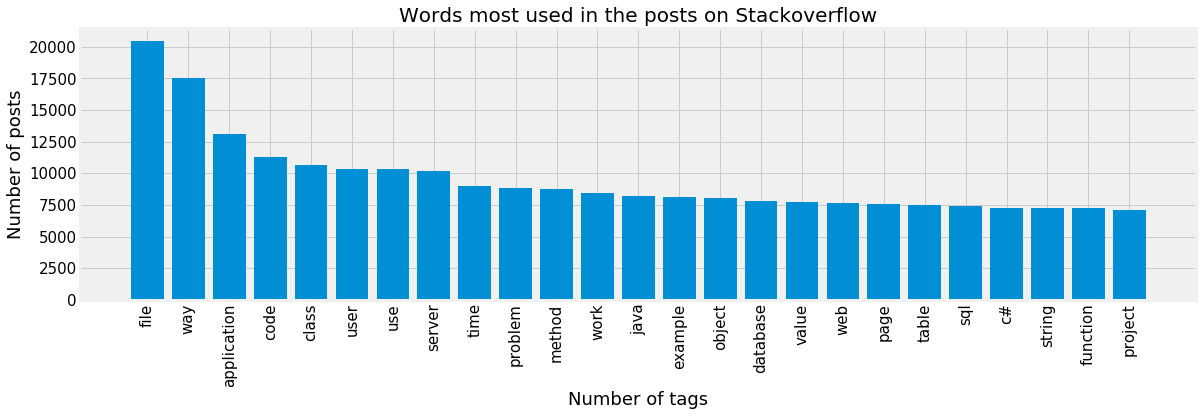

In [27]:
import matplotlib.pyplot as plt
from collections import Counter
# Graph showing the words most used in the post on Stackoverflow

word_count = Counter()
posts_body_clean6.apply(lambda x : word_count.update([s for s in x.split(' ') if s != ''])) ;

inv_specialtags = {v: k for k, v in dict(specialtags).items()}
for word in inv_specialtags.keys():
    if word in word_count.keys():
        word_count[inv_specialtags[word]] = word_count.pop(word)
        
result = pd.DataFrame(word_count.most_common(25),columns=['Word','Frequency'])

plt.figure(figsize=(20, 5))
plt.style.use('fivethirtyeight')
plt.xlabel('Number of tags', fontsize=18)
plt.ylabel('Number of posts', fontsize=18)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.bar(result.Word, result.Frequency)
plt.title("Words most used in the posts on Stackoverflow",fontsize=20)
plt.show()

In [28]:
result = pd.DataFrame(word_count.most_common(200),columns=['Word','Frequency'])
display(result)

,Word,Frequency
0,file,20459
1,way,17565
2,application,13099
3,code,11323
4,class,10690
5,user,10370
6,use,10362
7,server,10157
8,time,9004
9,problem,8812


Dans le lot, il y a des mots "fourre-tout" que j'intègre aux stopwords et je réapplique la fonction de suppression des stopwords. 

In [29]:
manual_stopwords = pd.read_excel("./common_words.xls").dropna(axis=0)['Word'].to_list()
print(manual_stopwords)
manual_stopwords = set(manual_stopwords)

['file', 'way', 'user', 'use', 'problem', 'work', 'example', 'method', 'question', 'page', 'value', 'error', 'type', 'thank', 'solution', 'thing', 'line', 'number', 'change', 'text', 'case', 'idea', 'tool', 'answer', 'edit', 'issue', 'update', 'lot', 'message', 'result', 'information', 'element', 'people', 'reason', 'help', 'return', 'want', 'run', 'developer', 'need', 'end', 'default', 'difference', 'set', 'development', 'suggestion', 'approach', 'task', 'implementation', 'check', 'e', 'custom', 'place', 'practice', 'support', 'experience', 'product', 'stuff', 'comment', 'note', 'argument', 'year']


In [30]:
posts_body_clean7 = posts_body_clean6.apply(lambda s: stopWordsRemove(s, manual_stopwords)) 

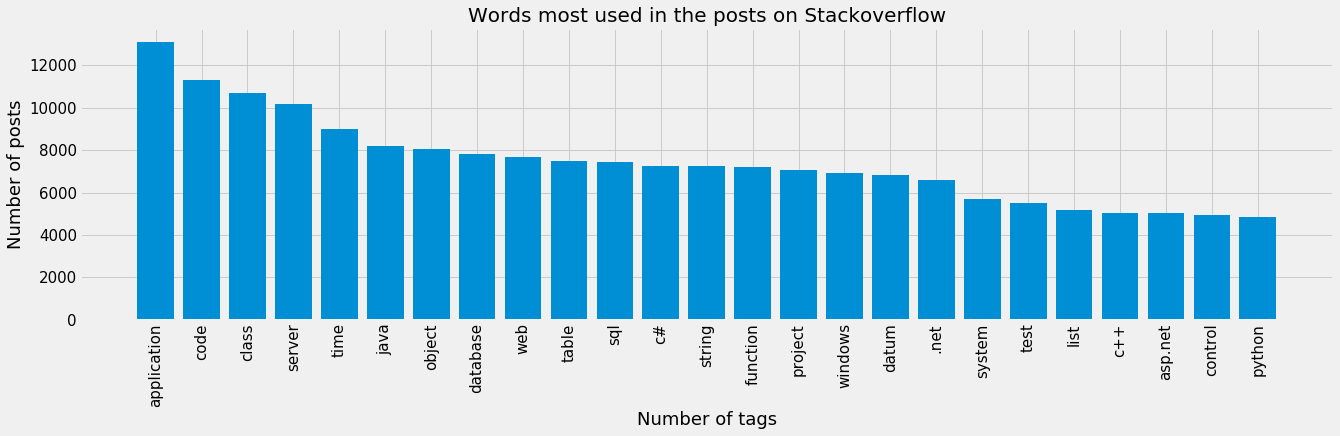

In [31]:
import matplotlib.pyplot as plt
from collections import Counter
# Graph showing the words most used in the post on Stackoverflow

word_count = Counter()
posts_body_clean7.apply(lambda x : word_count.update([s for s in x.split(' ') if s != ''])) ;

inv_specialtags = {v: k for k, v in dict(specialtags).items()}
for word in inv_specialtags.keys():
    if word in word_count.keys():
        word_count[inv_specialtags[word]] = word_count.pop(word)
        
result = pd.DataFrame(word_count.most_common(25),columns=['Word','Frequency'])

plt.figure(figsize=(20, 5))
plt.xlabel('Number of tags', fontsize=18)
plt.ylabel('Number of posts', fontsize=18)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.bar(result.Word, result.Frequency)
plt.title("Words most used in the posts on Stackoverflow",fontsize=20)
plt.style.use('fivethirtyeight')
plt.show()

In [32]:
# je compte les occurrences de chaque mot dans le dataframe
from collections import Counter
allwords_count = Counter()
posts_body_clean7.apply(lambda s : allwords_count.update(s.split(' '))) ;

In [33]:
posts_body_clean7 = posts_body_clean7.dropna(axis=0)
print('Taille finale du dataframe : {}'.format(posts_body_clean7.shape[0])) # NB: pas de documents vides après NLP
print('Nombre de mots distincts : {}'.format(len(allwords_count)))
print('Nombre total de mots : {}'.format(sum(allwords_count.values())))
print('Nombre moyen de mots par document : {:0.2f}'.format(sum(allwords_count.values())/posts_body_clean7.shape[0]))

Taille finale du dataframe : 48527
Nombre de mots distincts : 24103
Nombre total de mots : 914109
Nombre moyen de mots par document : 18.84


In [34]:
# SAUVEGARDE
with open('ignore_words.pkl', 'wb') as f:    
    pickle.dump(ignore_words, f)
with open('specialtags.pkl', 'wb') as f:    
    pickle.dump(specialtags, f)
with open('manual_stopwords.pkl', 'wb') as f:    
    pickle.dump(set(manual_stopwords), f)    
    
posts_body_clean7.to_pickle("./posts_body_clean.pkl")